In [25]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict,Annotated,Literal
from pydantic import BaseModel,Field
import operator

In [2]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [3]:
class PostFeedback(BaseModel):
    status : Literal['approved','needs_improvement'] = Field(description="Status of generated post")
    feedback : str = Field(description="Evalution feedback for the post")

In [28]:
class PostGenerationState(TypedDict):
    topic : str
    generated_content : str
    content_evalution : PostFeedback
    iteration : int
    max_iteration : int
    post_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]
    

In [29]:
def content_generation(state:PostGenerationState):
    topic = state['topic']
    response = llm.invoke(f"Generate a post on {topic}")
    return {'generated_content':response,'post_history':[response]}                                     

In [30]:
def content_evalution(state:PostGenerationState):
    content = state['generated_content']
    topic = state['topic']
    evalution_llm = llm.with_structured_output(PostFeedback)
    response = evalution_llm.invoke(f"Evalute the below content for given topic, You can say approved or needs_optimisation and provide the feedback also.\n"
                                                      f"Topic : {topic} \n"
                                                      f"Content : {content} ")
    return {'content_evalution':response,'feedback_history':[response]}                                                      

In [43]:
def content_regeneration(state:PostGenerationState):

    feedback = state['content_evalution'].feedback
    content = state['generated_content']
    topic = state['topic']
    response = llm.invoke(f"Regenerate the content for given topic, While regeneration see earlier response and feedback for the generated content.\n"
                                                    f"Topic : {topic} \n"
                                                    f"Earlier Content : {state['post_history']}\n "
                                                    f"Feedback : {state['feedback_history']}").content
    counter = state['iteration'] + 1
    return {'generated_content':response,'post_history':[response],'iteration':counter}   

In [44]:
def route_evaluation(state: PostGenerationState):

    print(state['iteration'], state['max_iteration'])
    if state['content_evalution'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

In [45]:
graph = StateGraph(PostGenerationState)
graph.add_node("Generation",content_generation)
graph.add_node("Evalution",content_evalution)
graph.add_node("Optimize",content_regeneration)
graph.add_edge(START,"Generation")
graph.add_edge("Generation","Evalution")
graph.add_conditional_edges('Evalution', route_evaluation, {'approved': END, 'needs_improvement': 'Optimize'})
graph.add_edge("Optimize","Evalution")
workflow = graph.compile()

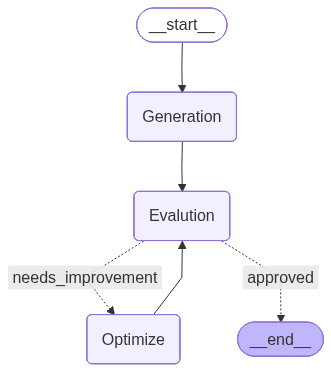

In [46]:
workflow

In [47]:
input_state = {'topic':'Future of TSLA stock','max_iteration':2,'iteration':1}
res = workflow.invoke(input_state)

1 2
2 2


In [48]:
res

{'topic': 'Future of TSLA stock',
 'generated_content': '## Tesla (TSLA): Navigating the Road Ahead - A Data-Driven Look at the Stock\'s Future\n\nTesla (TSLA) continues to be a captivating force in the automotive and energy sectors. But with increasing competition and evolving market dynamics, investors need a grounded perspective on the company\'s prospects. This analysis goes beyond the headlines, incorporating data and risk assessment to evaluate the future of TSLA stock.\n\nThe stock\'s journey has been marked by rapid growth and volatility. To understand its potential trajectory, we need to examine key factors with a critical eye.\n\n**Key Factors Influencing TSLA\'s Future Performance:**\n\n**Bullish Arguments:**\n\n*   **EV Market Leadership & Brand Power:** Tesla\'s brand recognition remains unparalleled in the EV market. While market share is being contested, Tesla currently holds approximately **[Insert Current Market Share Percentage]%** of the global EV market. The Superch

In [53]:
res['post_history'][0]

AIMessage(content="## Tesla (TSLA): Buckle Up for the Future - Where's the Stock Heading?\n\nTesla (TSLA) - the name conjures images of electric vehicles, groundbreaking technology, and a visionary leader. But beyond the hype, the question remains: **What does the future hold for TSLA stock?**\n\nThe stock has seen a wild ride in recent years, fueled by soaring demand, production challenges, and Elon Musk's often-controversial pronouncements. Now, with increased competition and evolving market dynamics, understanding the potential future trajectories of TSLA is crucial for any investor.\n\n**Here's a look at some key factors influencing TSLA's future performance:**\n\n**Bullish Arguments:**\n\n*   **Dominant EV Market Share:** Despite increasing competition, Tesla remains a leader in the EV space. Brand recognition, Supercharger network, and technological advancements give them a significant edge.\n*   **Energy Business Growth:** Beyond cars, Tesla's energy division (solar panels, batt

In [54]:
res['post_history'][1]

'## Tesla (TSLA): Navigating the Road Ahead - A Data-Driven Look at the Stock\'s Future\n\nTesla (TSLA) continues to be a captivating force in the automotive and energy sectors. But with increasing competition and evolving market dynamics, investors need a grounded perspective on the company\'s prospects. This analysis goes beyond the headlines, incorporating data and risk assessment to evaluate the future of TSLA stock.\n\nThe stock\'s journey has been marked by rapid growth and volatility. To understand its potential trajectory, we need to examine key factors with a critical eye.\n\n**Key Factors Influencing TSLA\'s Future Performance:**\n\n**Bullish Arguments:**\n\n*   **EV Market Leadership & Brand Power:** Tesla\'s brand recognition remains unparalleled in the EV market. While market share is being contested, Tesla currently holds approximately **[Insert Current Market Share Percentage]%** of the global EV market. The Supercharger network, with **[Insert Number]** stations globall